In [1]:
# !pip install kaggle
!pip install statsmodels 
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 28.3 MB/s 
     |████████████████████████████████| 9.8 MB 30.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle competitions download -c web-traffic-time-series-forecasting

 84% 85.0M/101M [00:01<00:00, 86.2MB/s]
100% 101M/101M [00:01<00:00, 90.4MB/s] 
 95% 142M/150M [00:01<00:00, 65.3MB/s]
100% 150M/150M [00:01<00:00, 81.4MB/s]
 95% 65.0M/68.2M [00:00<00:00, 81.4MB/s]
100% 68.2M/68.2M [00:00<00:00, 87.5MB/s]
 97% 64.0M/66.0M [00:00<00:00, 87.1MB/s]
100% 66.0M/66.0M [00:00<00:00, 90.3MB/s]
 98% 94.0M/96.0M [00:00<00:00, 136MB/s]
100% 96.0M/96.0M [00:00<00:00, 123MB/s]
100% 102M/102M [00:00<00:00, 127MB/s] 
100% 102M/102M [00:00<00:00, 122MB/s]


In [6]:
! unzip train_1.csv.zip
! unzip train_2.csv.zip

Archive:  train_1.csv.zip
  inflating: train_1.csv             
Archive:  train_2.csv.zip
  inflating: train_2.csv             


In [7]:
# Importing libraries
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pylab import rcParams
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Importing train_1 consisting of 550 dates
train_1 = pd.read_csv('train_1.csv').fillna(0)
print(train_1.shape)
train_1.head()

(145063, 551)


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,24.0,14.0,11.0,204.0,14.0,45.0,33.0,28.0,18.0,14.0,47.0,15.0,14.0,18.0,20.0,14.0,16.0,14.0,20.0,60.0,22.0,15.0,17.0,19.0,18.0,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,14.0,15.0,15.0,11.0,20.0,13.0,19.0,621.0,57.0,17.0,23.0,19.0,21.0,47.0,28.0,22.0,22.0,65.0,27.0,17.0,17.0,13.0,9.0,18.0,22.0,17.0,15.0,22.0,23.0,19.0,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,9.0,3.0,5.0,4.0,0.0,1.0,4.0,5.0,8.0,8.0,1.0,1.0,2.0,5.0,3.0,3.0,3.0,7.0,3.0,9.0,8.0,3.0,210.0,5.0,4.0,6.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,7.0,10.0,7.0,10.0,14.0,17.0,11.0,9.0,11.0,5.0,10.0,8.0,17.0,13.0,23.0,40.0,16.0,17.0,41.0,17.0,8.0,9.0,18.0,12.0,12.0,18.0,13.0,18.0,23.0,10.0,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,13.0,15.0,14.0,16.0,9.0,178.0,64.0,12.0,10.0,11.0,6.0,8.0,7.0,9.0,8.0,5.0,11.0,8.0,4.0,15.0,5.0,8.0,8.0,6.0,7.0,15.0,4.0,11.0,7.0,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [9]:
# Importing train_2 consisting of 803 dates for prediction
train_2 = pd.read_csv('train_2.csv').fillna(0)
print(train_2.shape)
train_2.head()

(145063, 804)


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,46.0,24.0,22.0,22.0,11.0,25.0,45.0,39.0,17.0,18.0,13.0,57.0,18.0,14.0,19.0,39.0,22.0,16.0,28.0,21.0,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,39.0,20.0,31.0,19.0,7.0,11.0,20.0,13.0,16.0,16.0,47.0,21.0,20.0,12.0,13.0,20.0,22.0,20.0,12.0,37.0,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,22.0,8.0,4.0,3.0,1.0,3.0,7.0,3.0,1.0,9.0,4.0,2.0,6.0,3.0,3.0,3.0,8.0,2.0,4.0,3.0,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,37.0,14.0,12.0,13.0,11.0,10.0,14.0,15.0,15.0,11.0,19.0,9.0,19.0,8.0,17.0,11.0,18.0,20.0,11.0,11.0,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.0,39.0,66.0,114.0,19.0,29.0,12.0,11.0,14.0,14.0,63.0,12.0,22.0,14.0,20.0,11.0,23.0,66.0,19.0,23.0,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [10]:
train1_main_df = pd.melt(train_1[list(train_1.columns[-550:])+['Page']], id_vars='Page', var_name='Date', value_name='Visits')
train1_main_df['Date'] = train1_main_df['Date'].astype('datetime64[ns]')
print(train1_main_df.shape)
train1_main_df.head()

(79784650, 3)


,Page,Date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0


In [11]:
train2_main_df = pd.melt(train_2[list(train_2.columns[-253:])+['Page']], id_vars='Page', var_name='Date', value_name='Visits')
train2_main_df['Date'] = train2_main_df['Date'].astype('datetime64[ns]')
print(train2_main_df.shape)
train2_main_df.head()

(36700939, 3)


,Page,Date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2017-01-01,26.0
1,2PM_zh.wikipedia.org_all-access_spider,2017-01-01,27.0
2,3C_zh.wikipedia.org_all-access_spider,2017-01-01,13.0
3,4minute_zh.wikipedia.org_all-access_spider,2017-01-01,12.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2017-01-01,8.0


In [12]:
# For visualization, consider just 100 dates
train1_df = pd.melt(train_1[list(train_1.columns[-100:])+['Page']], id_vars='Page', var_name='Date', value_name='Visits')
train1_df['Date'] = train1_df['Date'].astype('datetime64[ns]')
train1_df['Weekend'] = ((train1_df.Date.dt.dayofweek) // 5 == 1).astype(float)
print(train1_df.shape)
train1_df.head()

(14506300, 4)


,Page,Date,Visits,Weekend
0,2NE1_zh.wikipedia.org_all-access_spider,2016-09-23,10.0,0.0
1,2PM_zh.wikipedia.org_all-access_spider,2016-09-23,26.0,0.0
2,3C_zh.wikipedia.org_all-access_spider,2016-09-23,3.0,0.0
3,4minute_zh.wikipedia.org_all-access_spider,2016-09-23,14.0,0.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2016-09-23,3.0,0.0


In [13]:
# Median by page
median_df = pd.DataFrame(train1_df.groupby(['Page'])['Visits'].median())
median_df.columns = ['Median']

# Average by page
mean_df = pd.DataFrame(train1_df.groupby(['Page'])['Visits'].mean())
mean_df.columns = ['Mean']

# Merging data
train1_df = train1_df.set_index('Page').join(mean_df).join(median_df)
train1_df.reset_index(drop=False,inplace=True)

# Calculating WeekDay, Year, Month and Day columns
train1_df['Weekday'] = train1_df['Date'].apply(lambda x: x.weekday())
train1_df['Year'] = train1_df.Date.dt.year 
train1_df['Month'] = train1_df.Date.dt.month 
train1_df['Day'] = train1_df.Date.dt.day
print(train1_df.shape)
train1_df.head()

(14506300, 10)


,Page,Date,Visits,Weekend,Mean,Median,Weekday,Year,Month,Day
0,!vote_en.wikipedia.org_all-access_all-agents,2016-09-23,3.0,0.0,3.46,3.0,4,2016,9,23
1,!vote_en.wikipedia.org_all-access_all-agents,2016-09-24,1.0,1.0,3.46,3.0,5,2016,9,24
2,!vote_en.wikipedia.org_all-access_all-agents,2016-09-25,2.0,1.0,3.46,3.0,6,2016,9,25
3,!vote_en.wikipedia.org_all-access_all-agents,2016-09-26,7.0,0.0,3.46,3.0,0,2016,9,26
4,!vote_en.wikipedia.org_all-access_all-agents,2016-09-27,5.0,0.0,3.46,3.0,1,2016,9,27


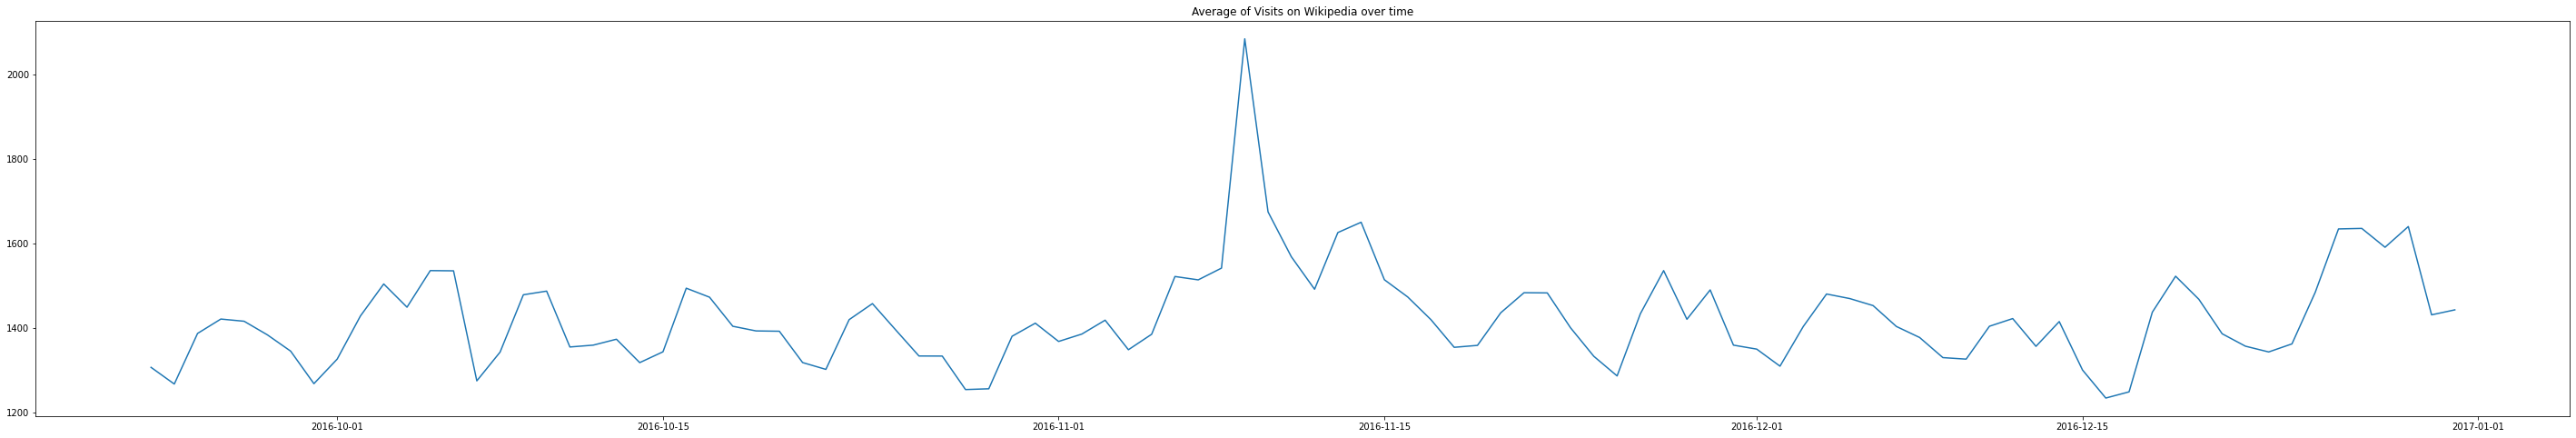

In [14]:
plt.figure(figsize=(50, 8))
avg_df = train1_df[['Page','Date','Visits']].groupby(['Date'])['Visits'].mean()
plt.plot(avg_df)
plt.title('Average of Visits on Wikipedia over time')
plt.show()

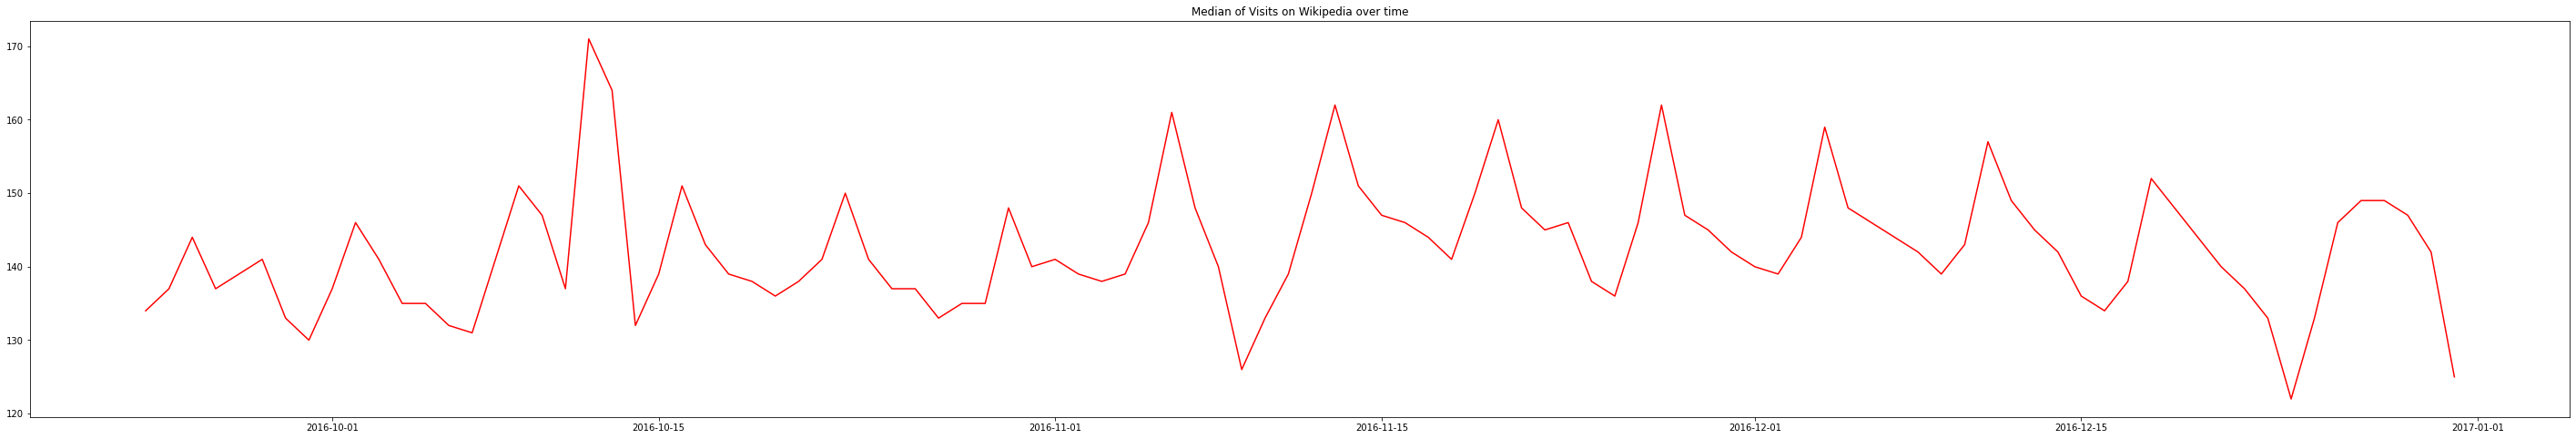

In [15]:
plt.figure(figsize=(50, 8))
med_df = train1_df[['Page','Date','Visits']].groupby(['Date'])['Visits'].median()
plt.plot(med_df, color = 'r')
plt.title('Median of Visits on Wikipedia over time')
plt.show()

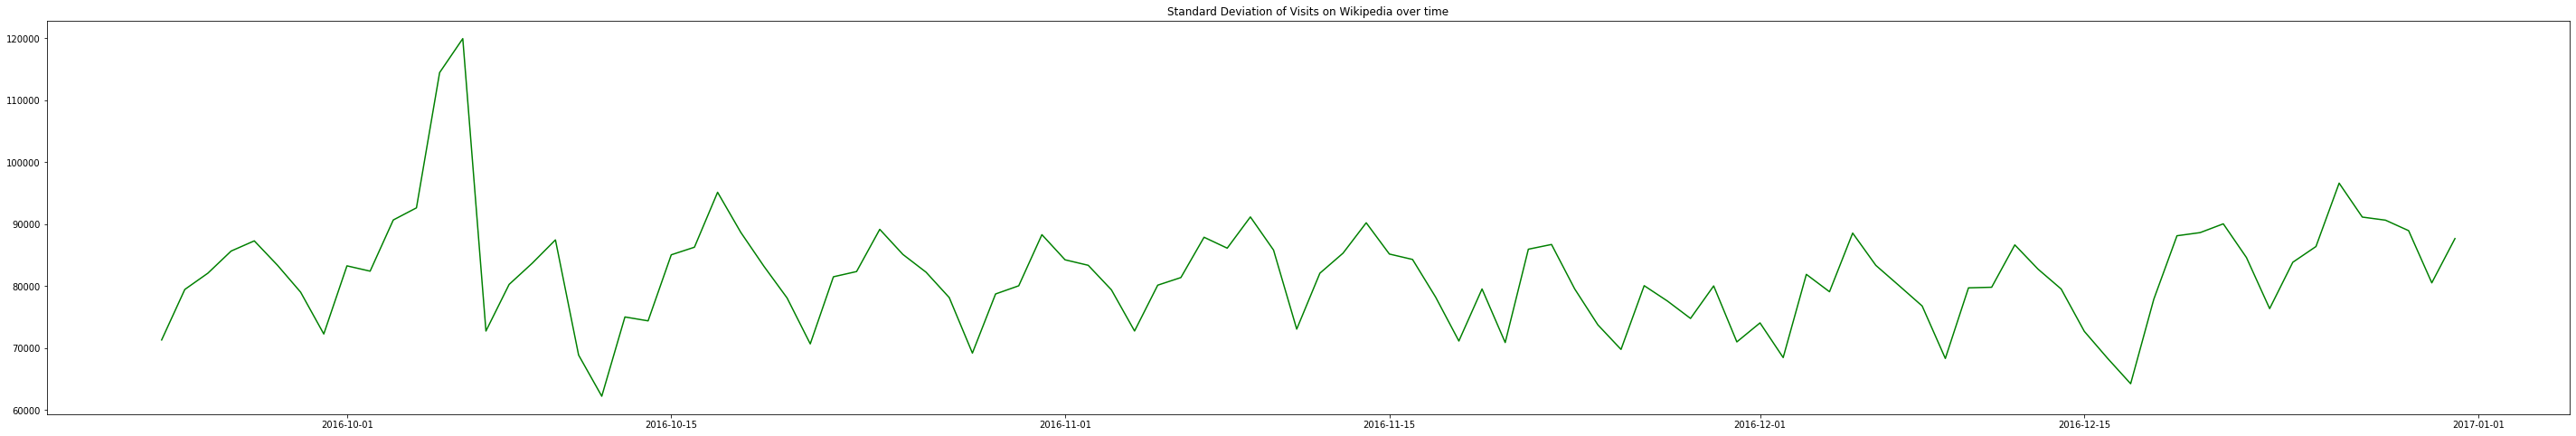

In [16]:
plt.figure(figsize=(50, 8))
std_df = train1_df[['Page','Date','Visits']].groupby(['Date'])['Visits'].std()
plt.plot(std_df, color = 'g')
plt.title('Standard Deviation of Visits on Wikipedia over time')
plt.show()

In [17]:
ts_data =  pd.DataFrame(avg_df).reset_index(drop=False)
ts_data['Weekday'] = ts_data['Date'].apply(lambda x: x.weekday())
ts_data['Date_str'] = ts_data['Date'].apply(lambda x: str(x))
ts_data[['Year','Month','Day']] = pd.DataFrame(ts_data['Date_str'].str.split('-',2).tolist(), columns = ['Year','Month','Day'])
date_staging = pd.DataFrame(ts_data['Day'].str.split(' ',2).tolist(), columns = ['Day','other'])
ts_data['Day'] = date_staging['Day']*1
ts_data.drop('Date_str',axis = 1, inplace =True)
print(ts_data.shape)
ts_data.head()

(100, 6)


,Date,Visits,Weekday,Year,Month,Day
0,2016-09-23,1307.048910,4,2016,09,23
1,2016-09-24,1267.586759,5,2016,09,24
2,2016-09-25,1387.193523,6,2016,09,25
3,2016-09-26,1421.203967,0,2016,09,26
4,2016-09-27,1416.020715,1,2016,09,27


In [18]:
ts1_final = train1_main_df[['Page','Date','Visits']].groupby(['Date'])['Visits'].mean().reset_index(drop=False).set_index('Date')
ts2_final = train2_main_df[['Page','Date','Visits']].groupby(['Date'])['Visits'].mean().reset_index(drop=False).set_index('Date')
print(ts1_final.shape, ts2_final.shape)
ts1_final.head()
# ts_data.reset_index(drop=True,inplace=True)
# ts_final = temp_df[['Date','Visits']].set_index('Date')
# print(ts_final.head())

(550, 1) (253, 1)


,Visits
Date,
2015-07-01,1024.882127
2015-07-02,1031.233602
2015-07-03,973.123388
2015-07-04,1003.791022
2015-07-05,1044.341920


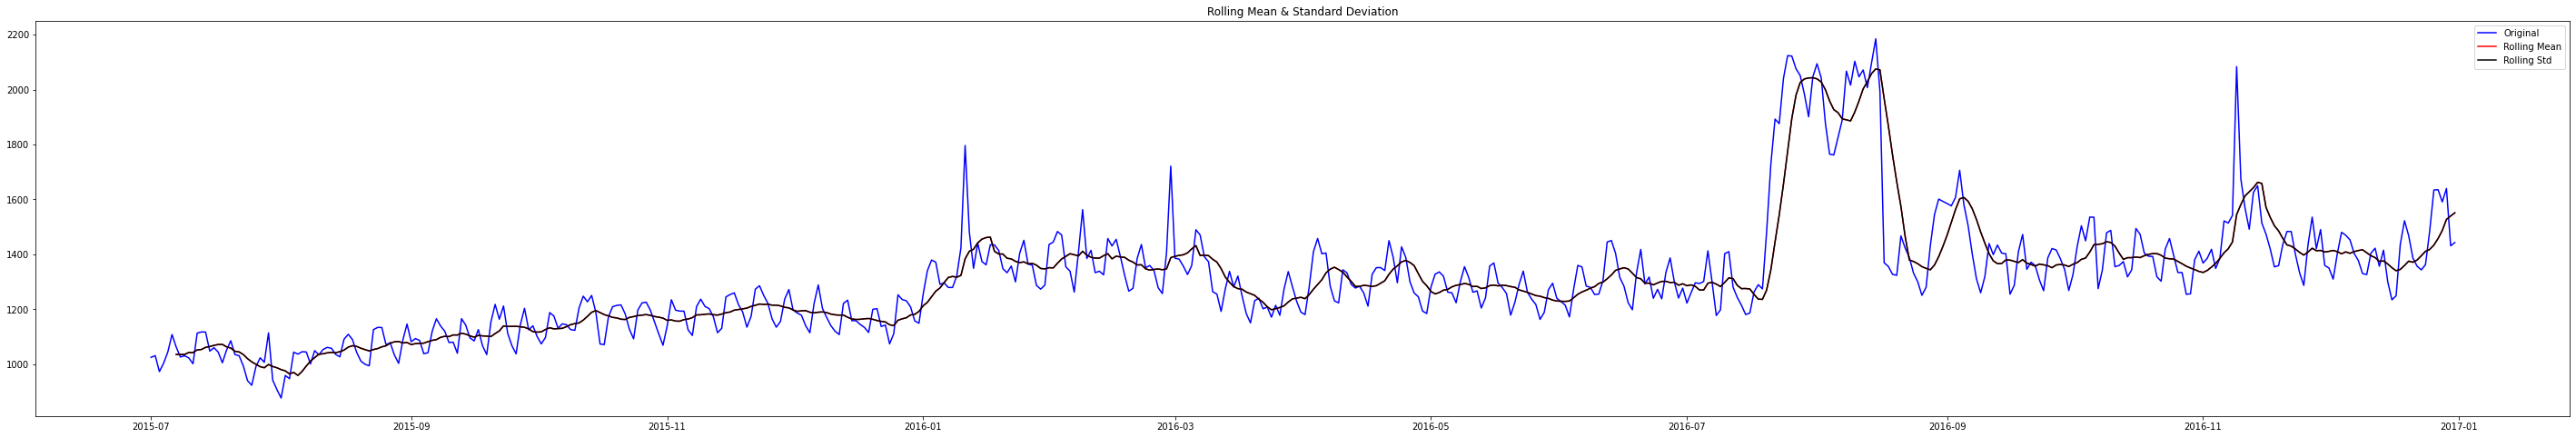

Results of Dickey-Fuller Test:
Test Statistic                  -2.436633
p-value                          0.131663
#Lags Used                      14.000000
Number of Observations Used    535.000000
Critical Value (1%)             -3.442632
Critical Value (5%)             -2.866957
Critical Value (10%)            -2.569655
dtype: float64


In [19]:
# Show Rolling mean, Rolling standard deviation and Test for the stationarity
def test_stationarity(timeseries):
    plt.figure(figsize=(50, 8))
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).mean()

    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.adfuller(timeseries['Visits'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(ts1_final)

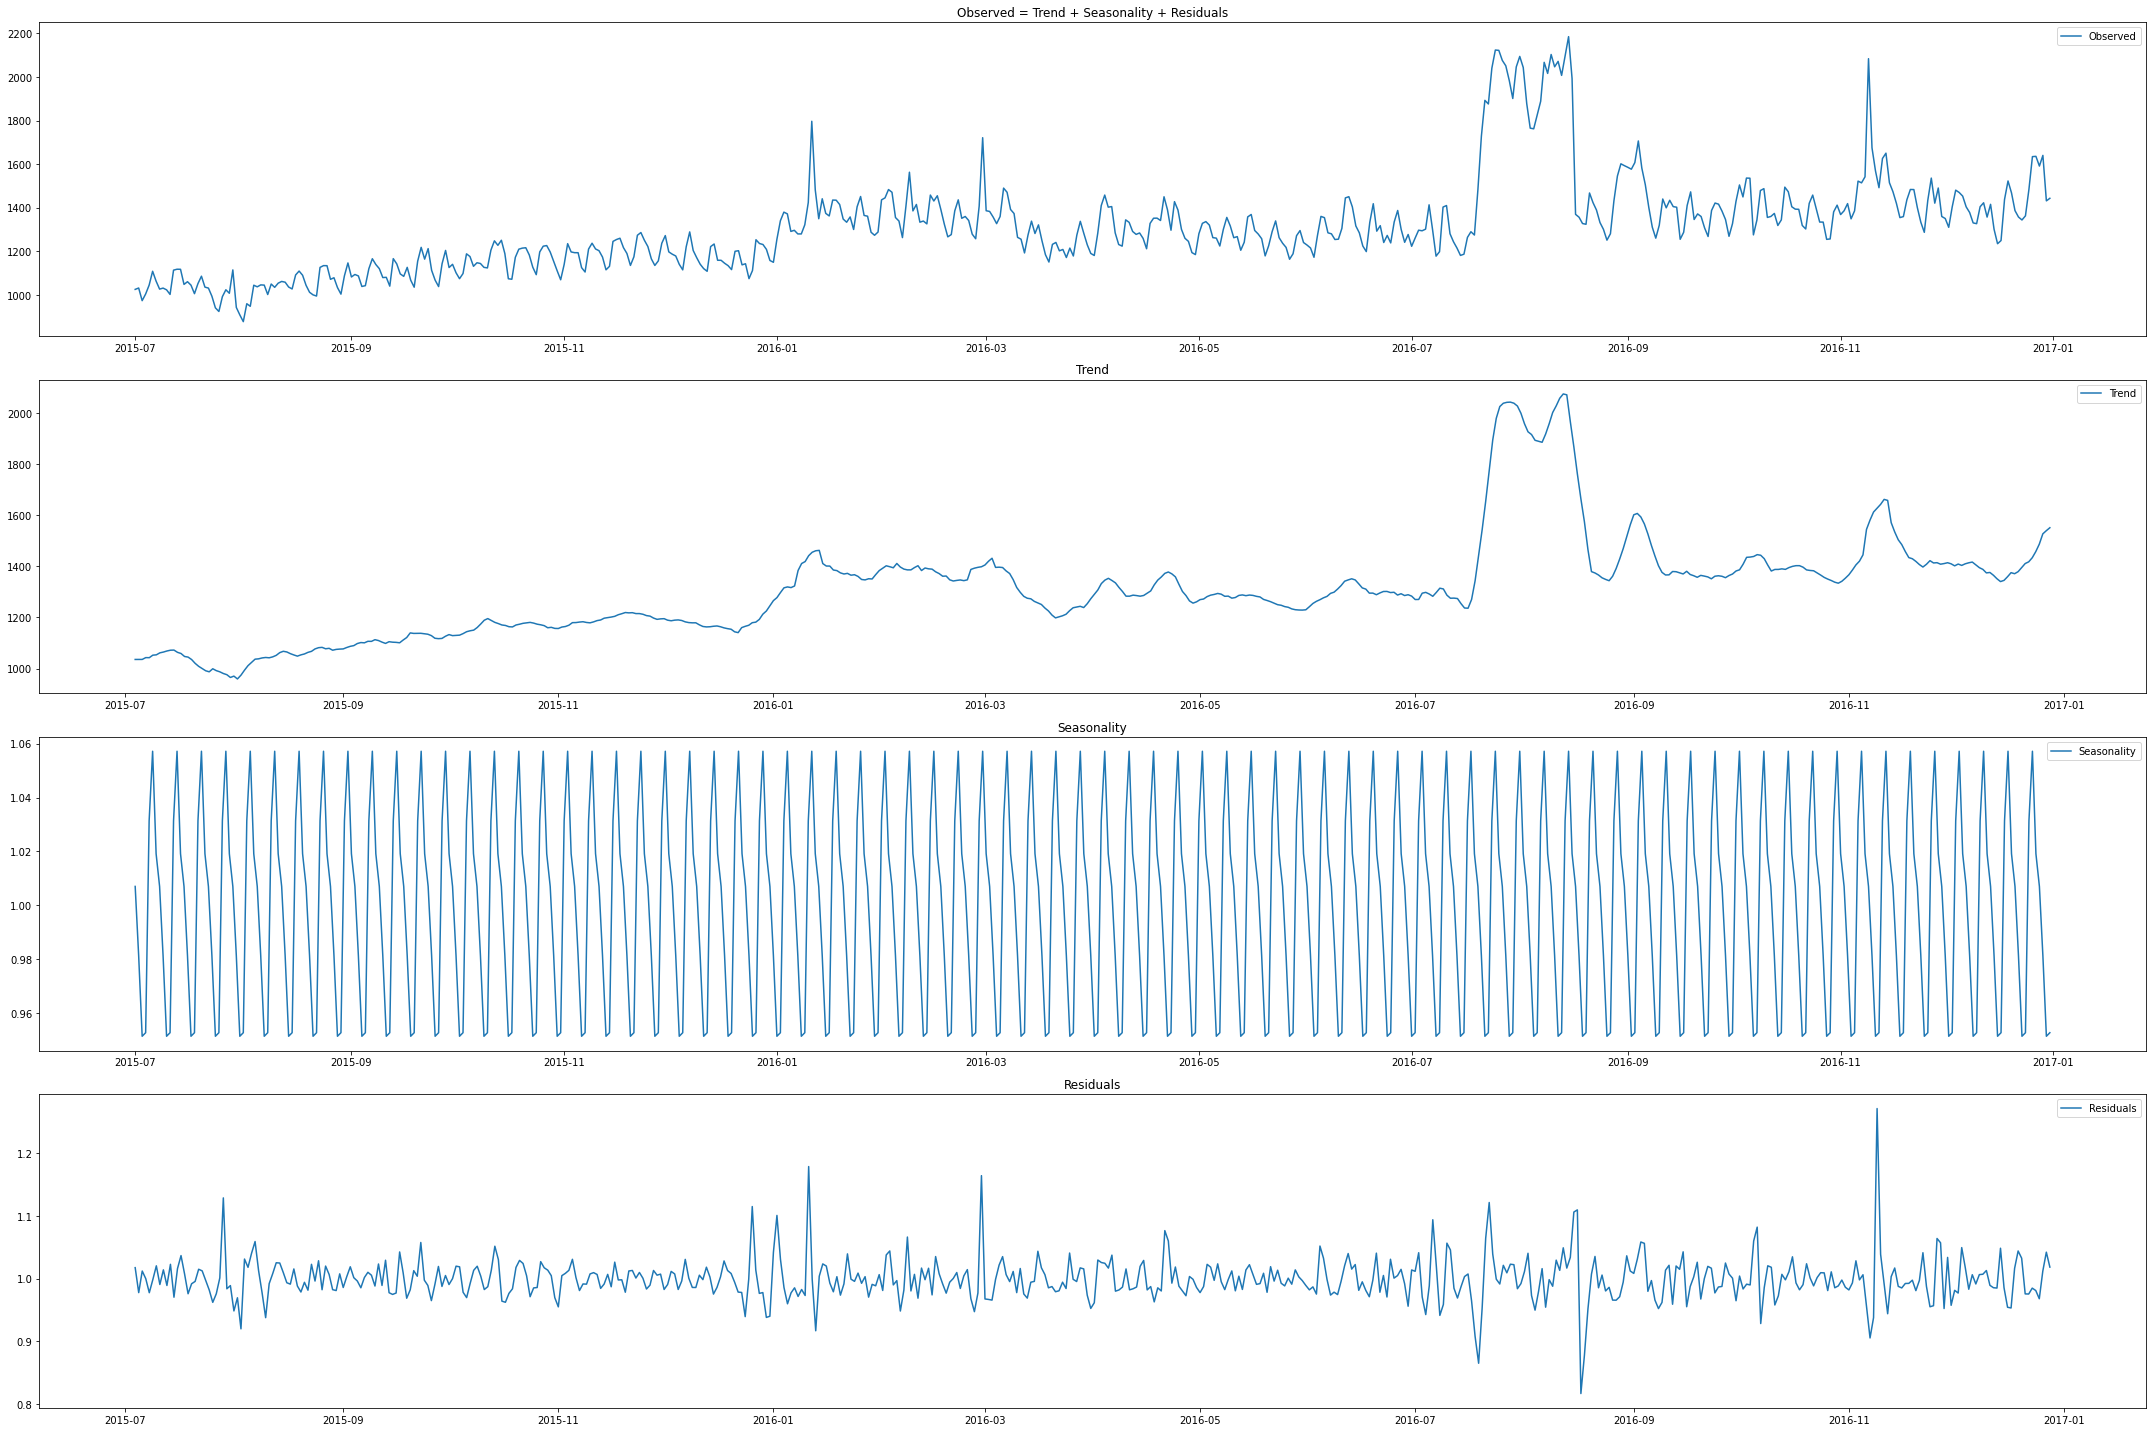

In [20]:
# Naive decomposition of the Time Series
decomposition = sm.tsa.seasonal_decompose(ts1_final, model='multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
rcParams['figure.figsize'] = 30, 20

plt.subplot(411)
plt.title('Observed = Trend + Seasonality + Residuals')
plt.plot(ts1_final, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.title('Trend')
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.title('Seasonality')
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.title('Residuals')
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

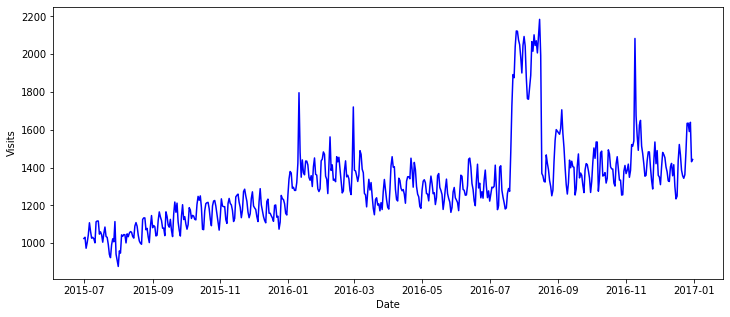

In [21]:
# Plotting our train_1 timeseries data variation over time
plt.figure(figsize=(12, 5))
orig = plt.plot(ts1_final['Visits'], color='blue')
plt.ylabel('Visits')
plt.xlabel('Date')
plt.show(block=False)

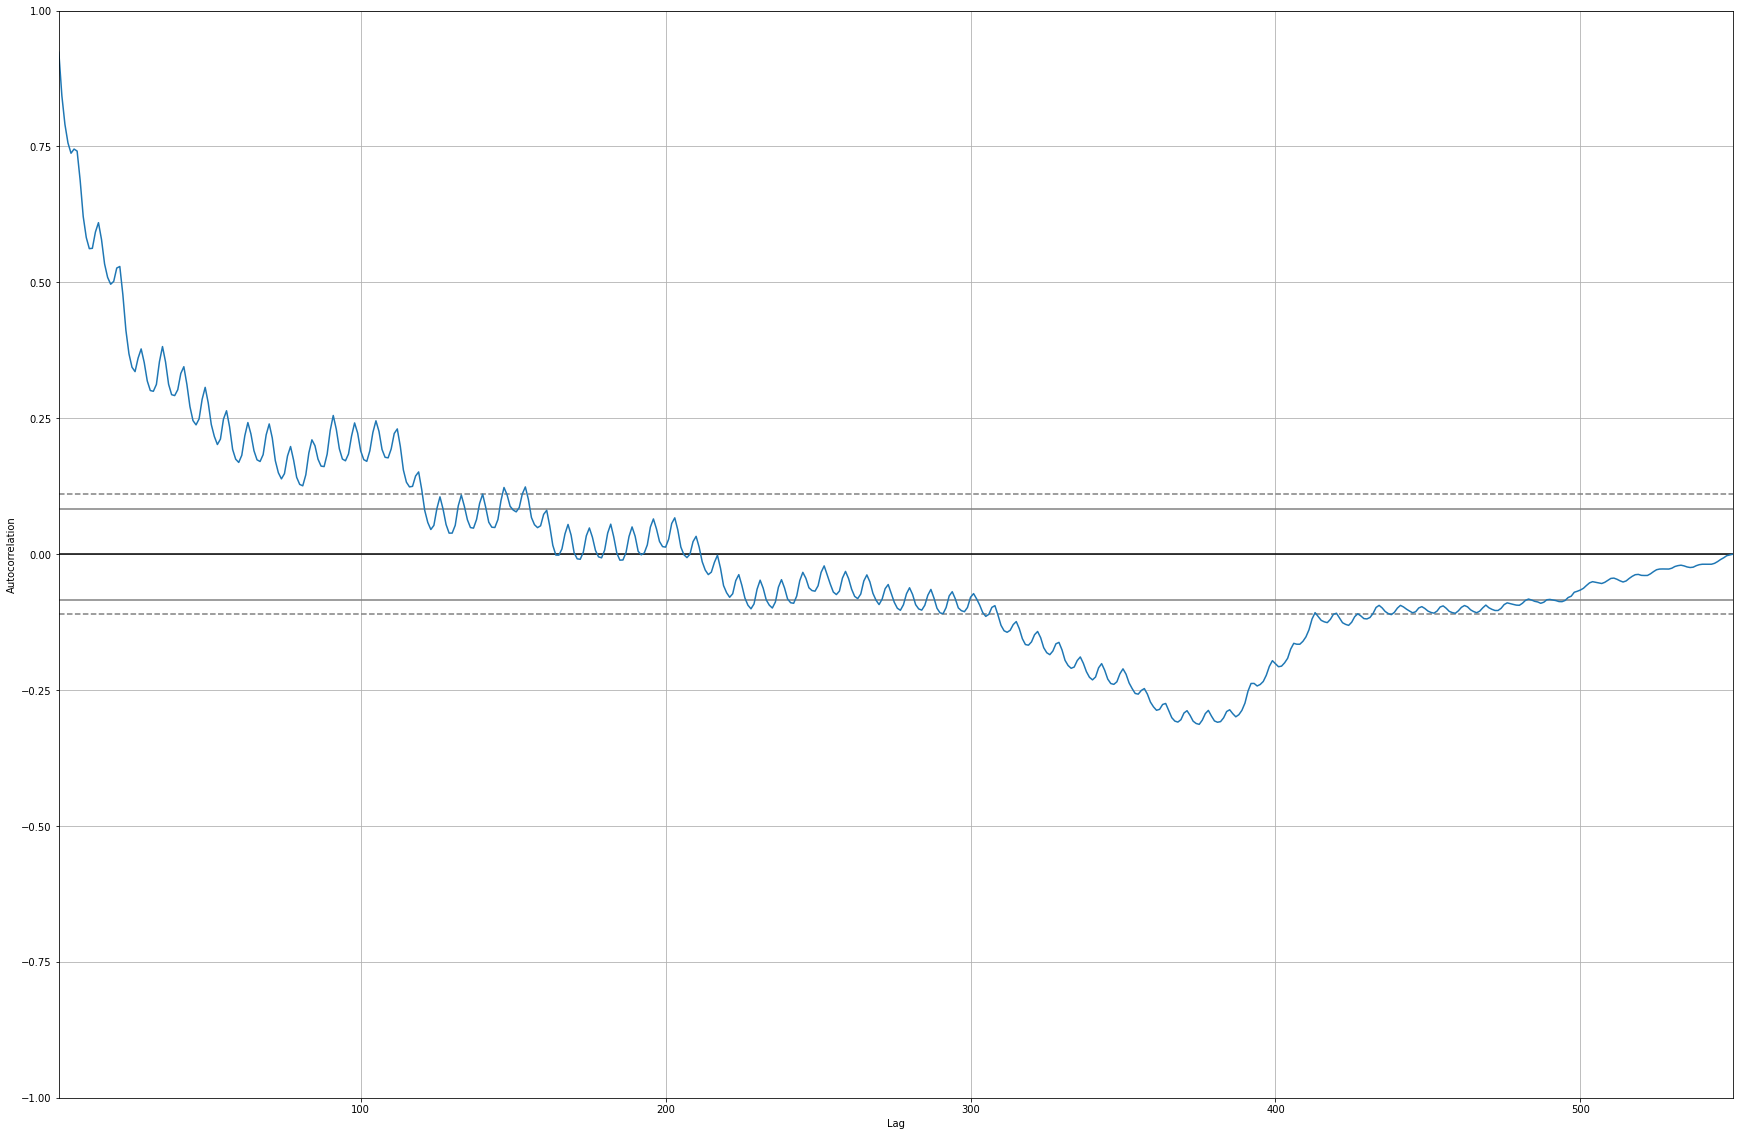

In [22]:
# Auto Correlation Plot
pd.plotting.autocorrelation_plot(ts1_final['Visits'])

In [23]:
# Augmented Dickey Fuller Test
def adf_test(dataset):
     test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",test[0])
     print("2. P-Value : ", test[1])
     print("3. Num Of Lags : ", test[2])
     print("4. Num Of Observations Used For ADF Regression:", test[3])
     print("5. Critical Values :")
     for key, val in test[4].items():
         print("\t",key, ": ", val)

adf_test(ts1_final['Visits'])

1. ADF :  -2.436632694929488
2. P-Value :  0.13166285090995383
3. Num Of Lags :  14
4. Num Of Observations Used For ADF Regression: 535
5. Critical Values :
	 1% :  -3.4426321555520905
	 5% :  -2.86695748394138
	 10% :  -2.5696553279762426


In [24]:
from pmdarima import auto_arima

auto_arima = auto_arima(ts1_final.Visits, 
                        test='adf',
                        d=1, 
                        D=1, 
                        trace=True, 
                        error_action='ignore', 
                        suppress_warnings=True, 
                        stepwise=True)
print(auto_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6330.186, Time=1.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6429.908, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6431.580, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6431.385, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6427.953, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6391.125, Time=0.54 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6390.321, Time=0.56 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6394.318, Time=0.99 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6392.732, Time=0.80 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6392.214, Time=0.83 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.88 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=1.22 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total 

In [25]:
train, test = ts1_final.iloc[:-50], ts1_final.iloc[-50:]
# train, test = ts1_final, ts2_final
print(train.shape, test.shape)
test.head()

(500, 1) (50, 1)


,Visits
Date,
2016-11-12,1491.626266
2016-11-13,1625.662602
2016-11-14,1650.061015
2016-11-15,1514.151238
2016-11-16,1473.522090


In [26]:
# Give order value based on above results
model = ARIMA(train.Visits, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 Visits   No. Observations:                  500
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2873.609
Date:                Fri, 10 Dec 2021   AIC                           5757.219
Time:                        07:30:21   BIC                           5778.282
Sample:                    07-01-2015   HQIC                          5765.484
                         - 11-11-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2463      0.003    457.883      0.000       1.241       1.252
ar.L2         -0.9996      0.002   -464.934      0.000      -1.004      -0.995
ma.L1         -1.2376      0.019    -65.952      0.0

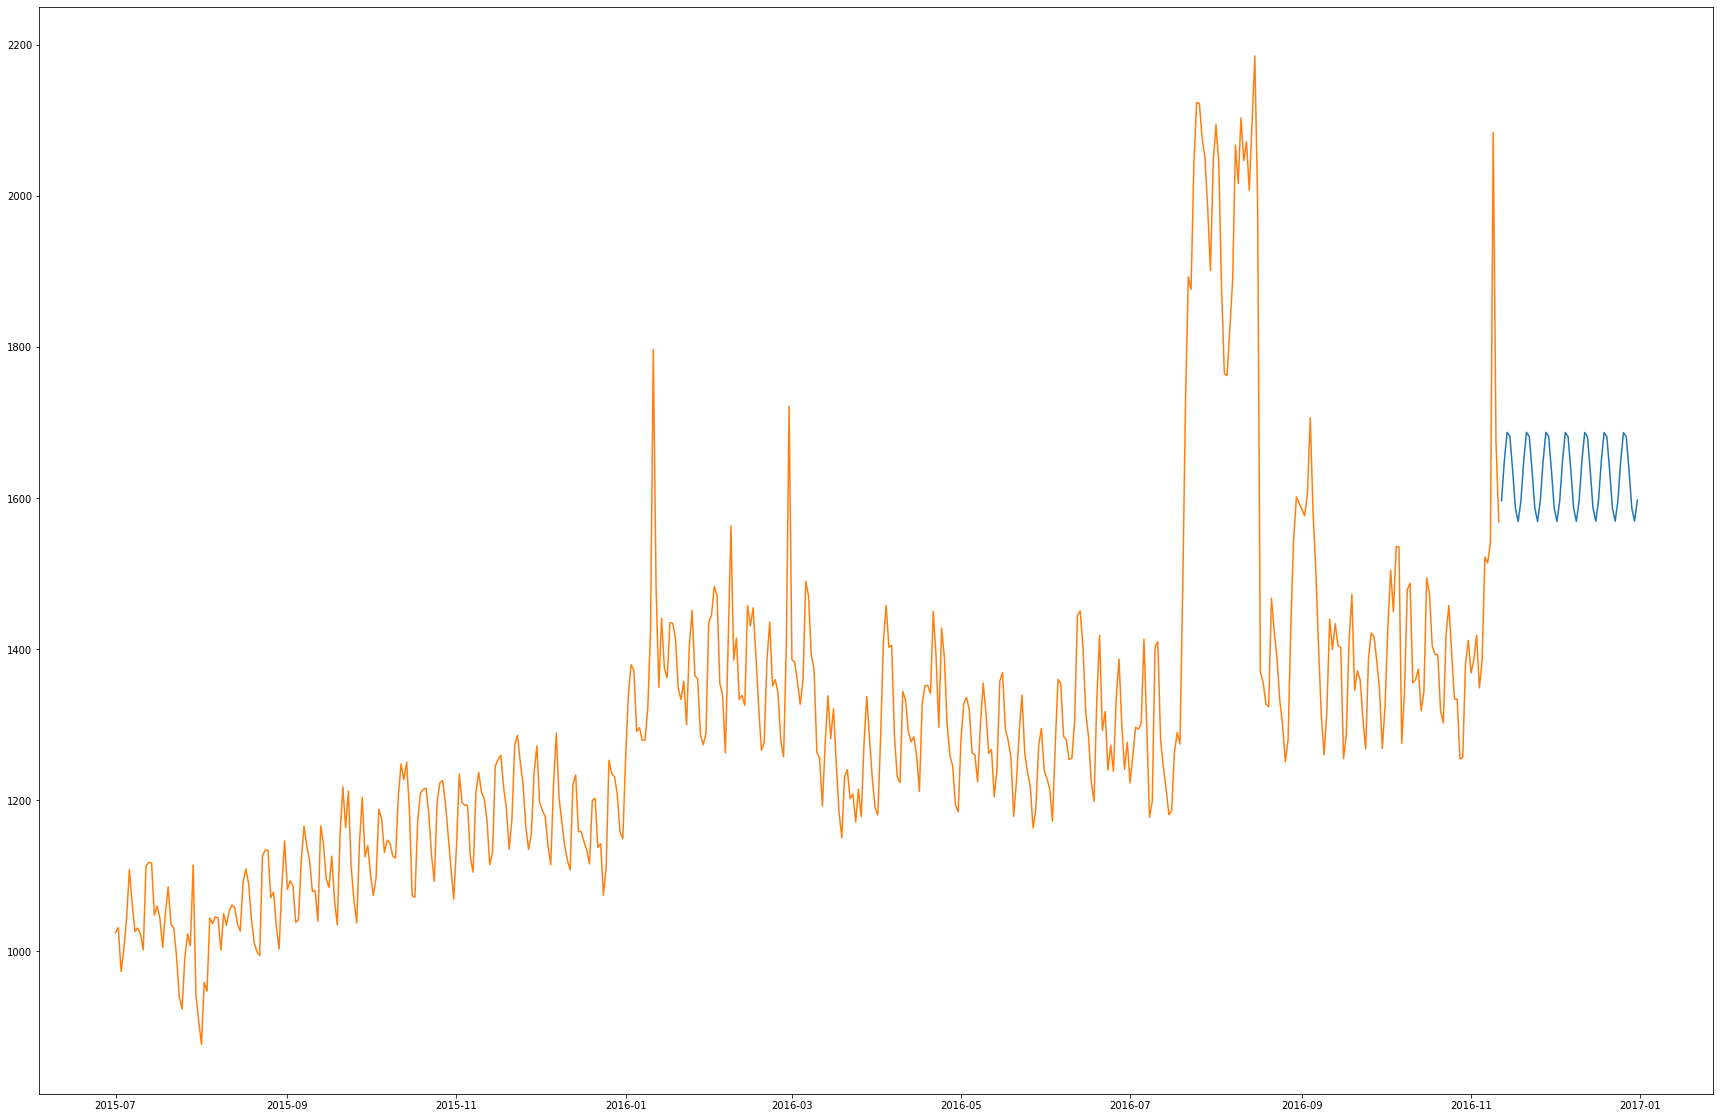

In [27]:
# Plot predicted values
predicted = model_fit.forecast(50)
plt.plot(predicted)
plt.plot(train.Visits)

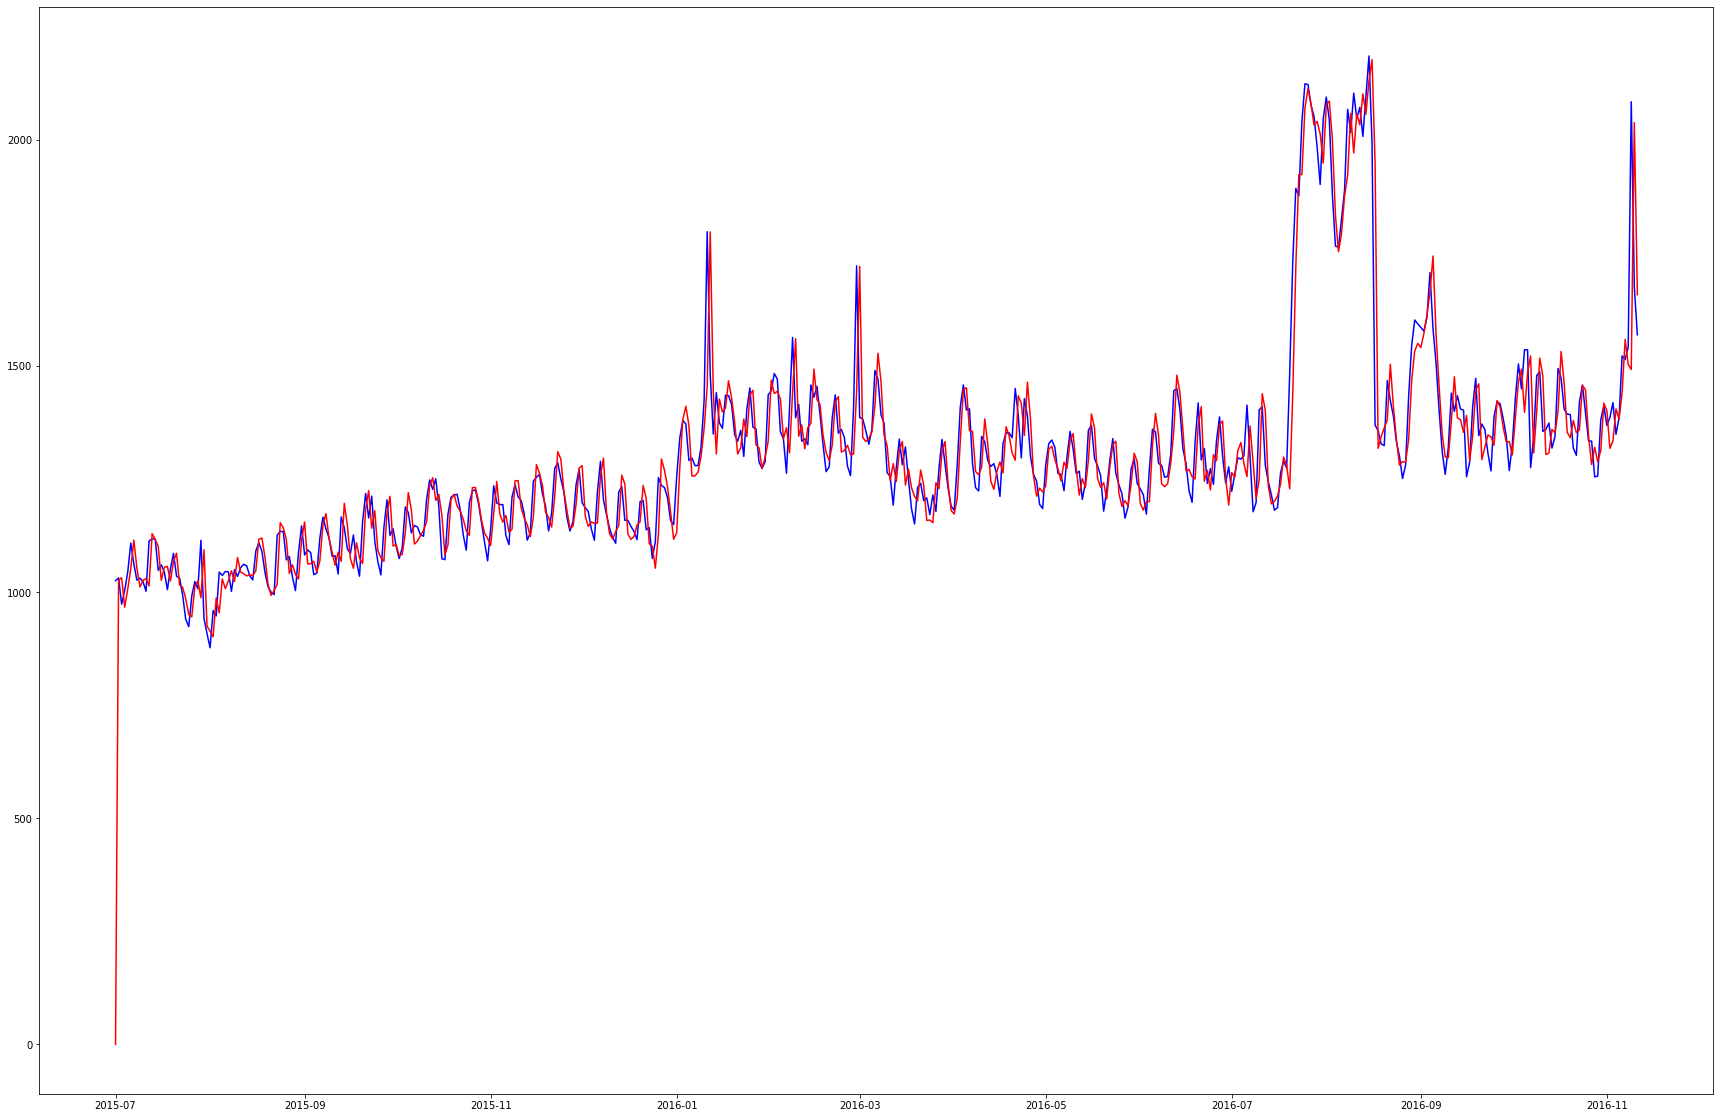

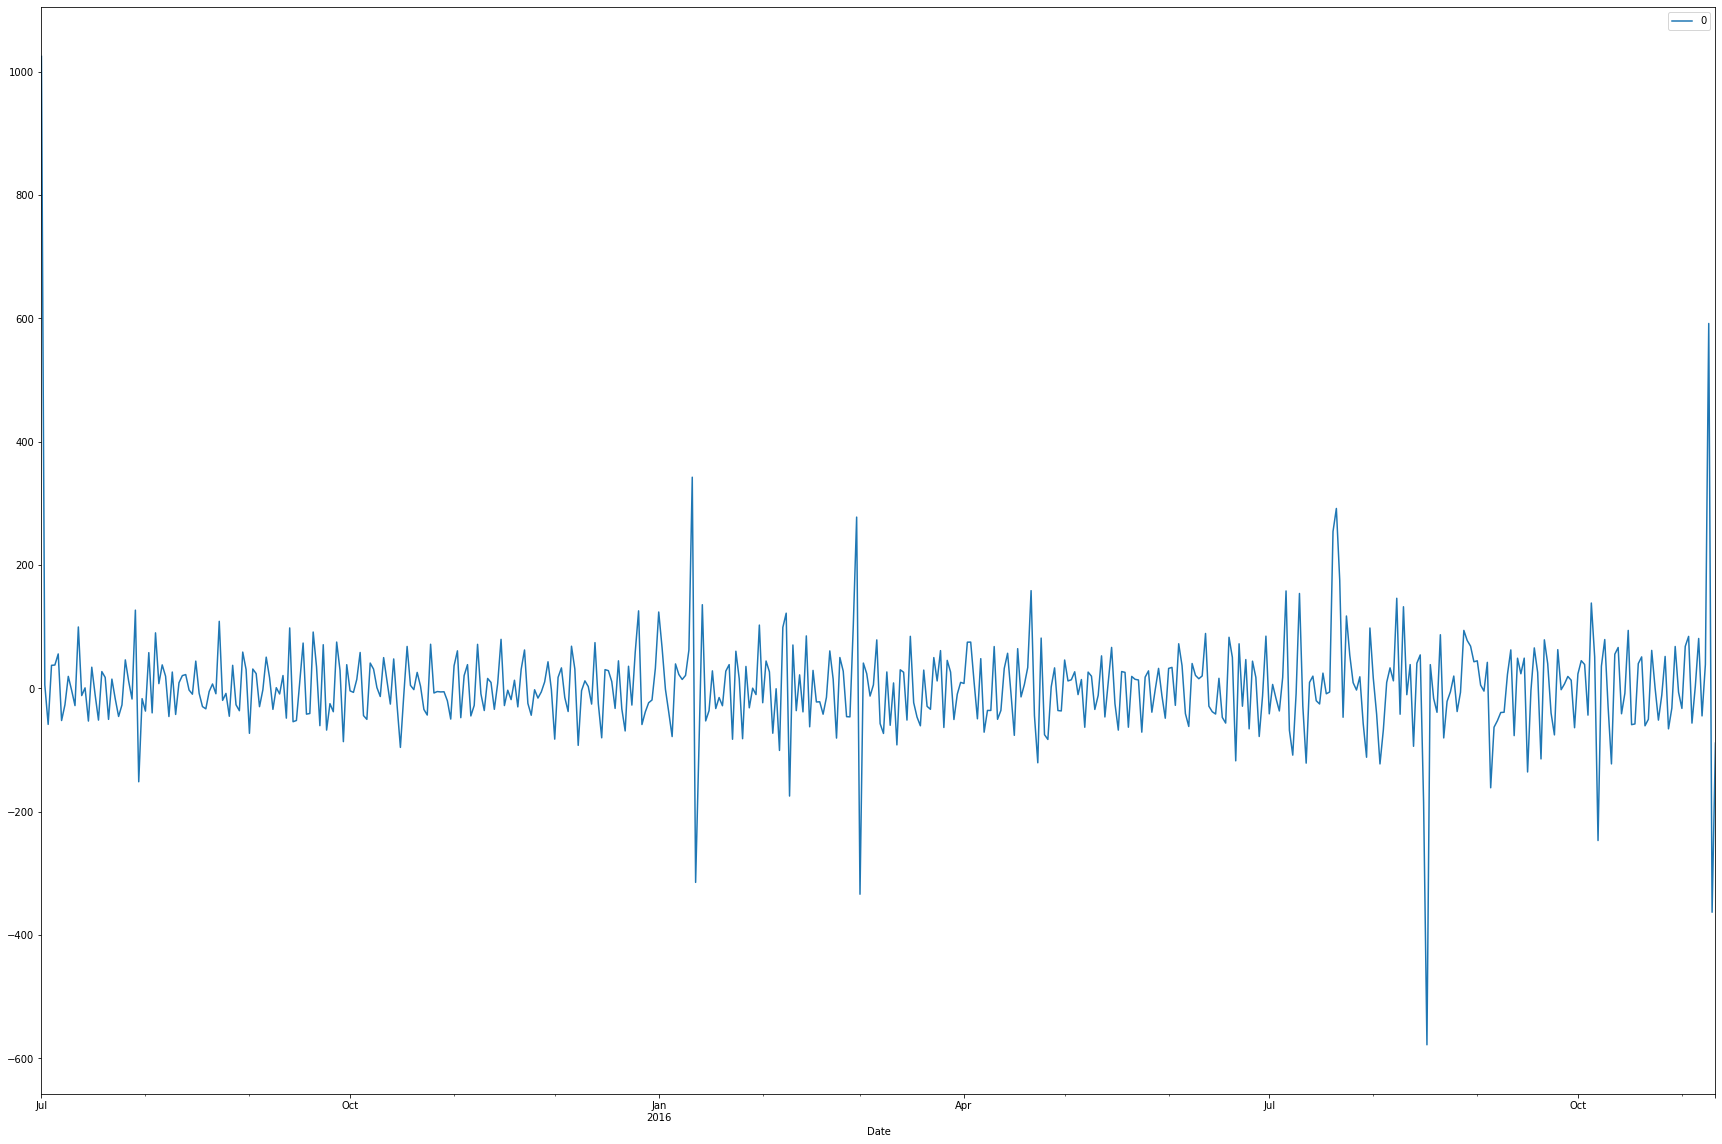

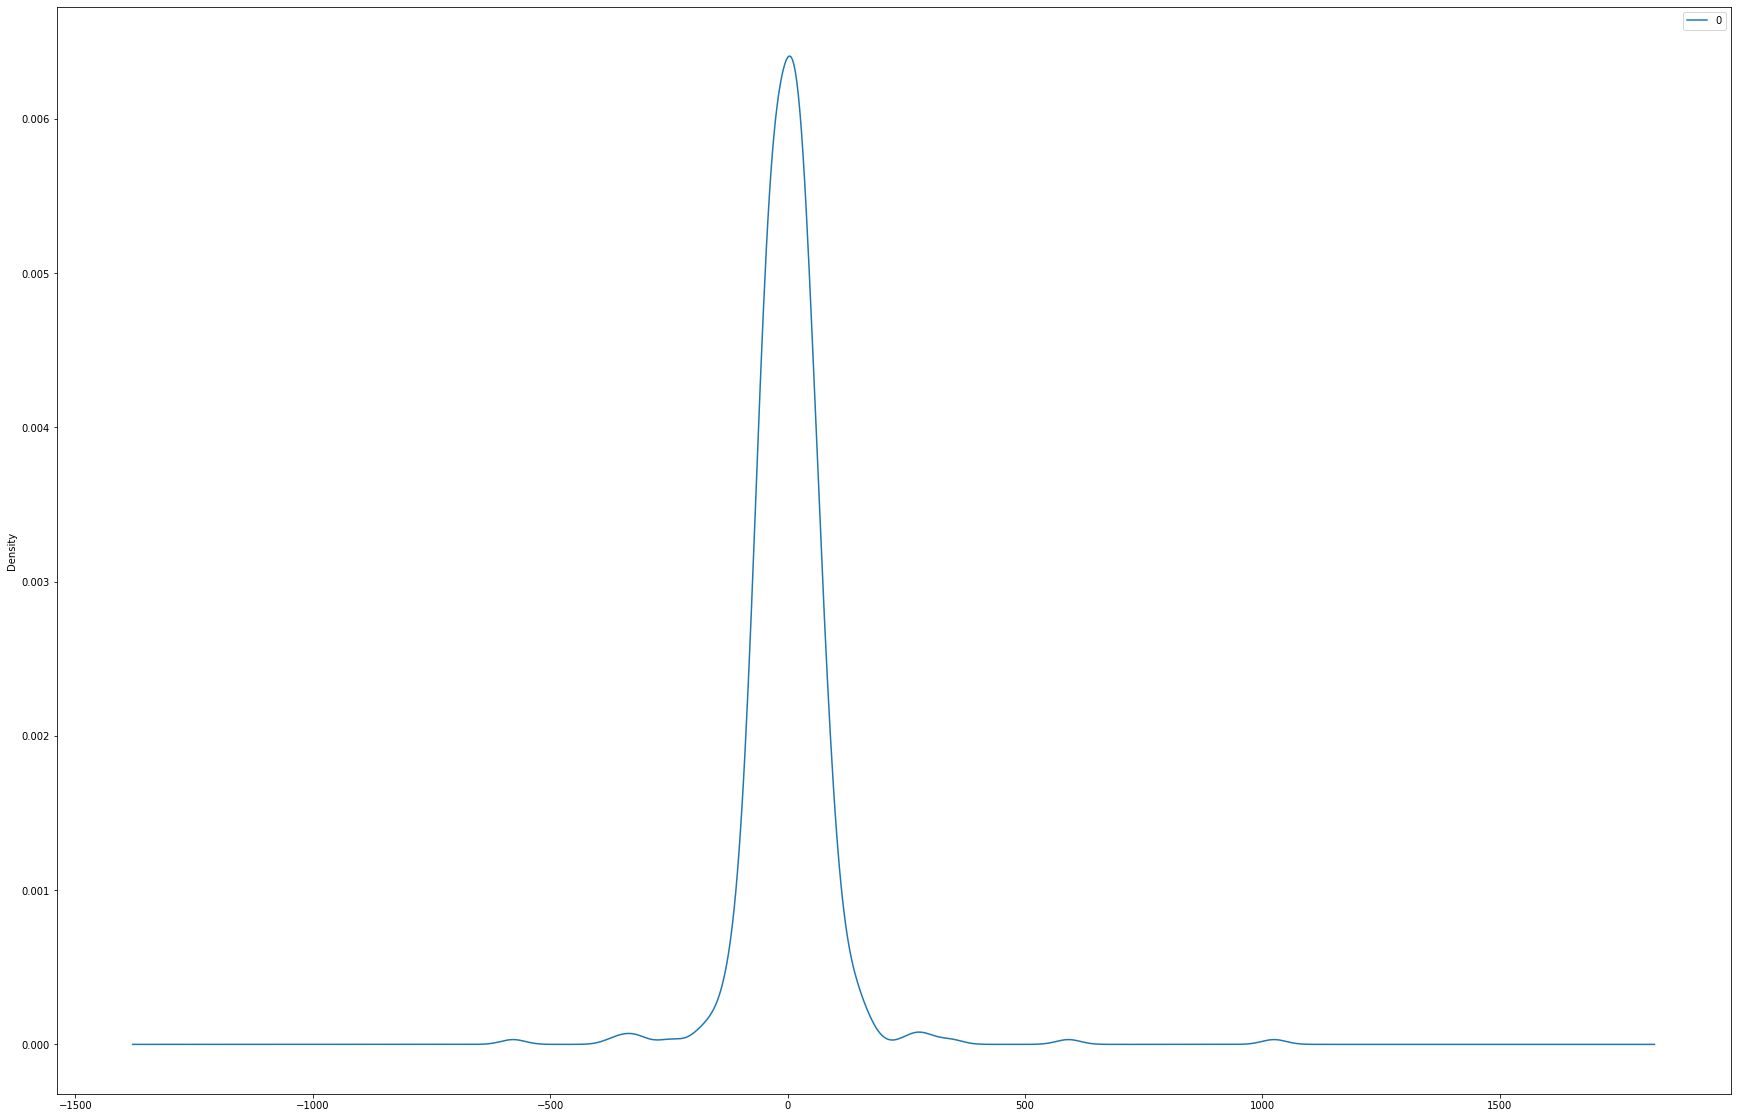

                 0
count   500.000000
mean      3.269352
std      88.918490
min    -578.019946
25%     -37.839147
50%       1.082333
75%      37.909505
max    1024.882127


In [28]:
plt.plot(train, color = 'blue')
plt.plot(model_fit.fittedvalues, color='red')
plt.show()
# Residual plot
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# Density plot of residuals
residuals.plot(kind='kde')
plt.show()
# Summary of residuals
print(residuals.describe())

500 549


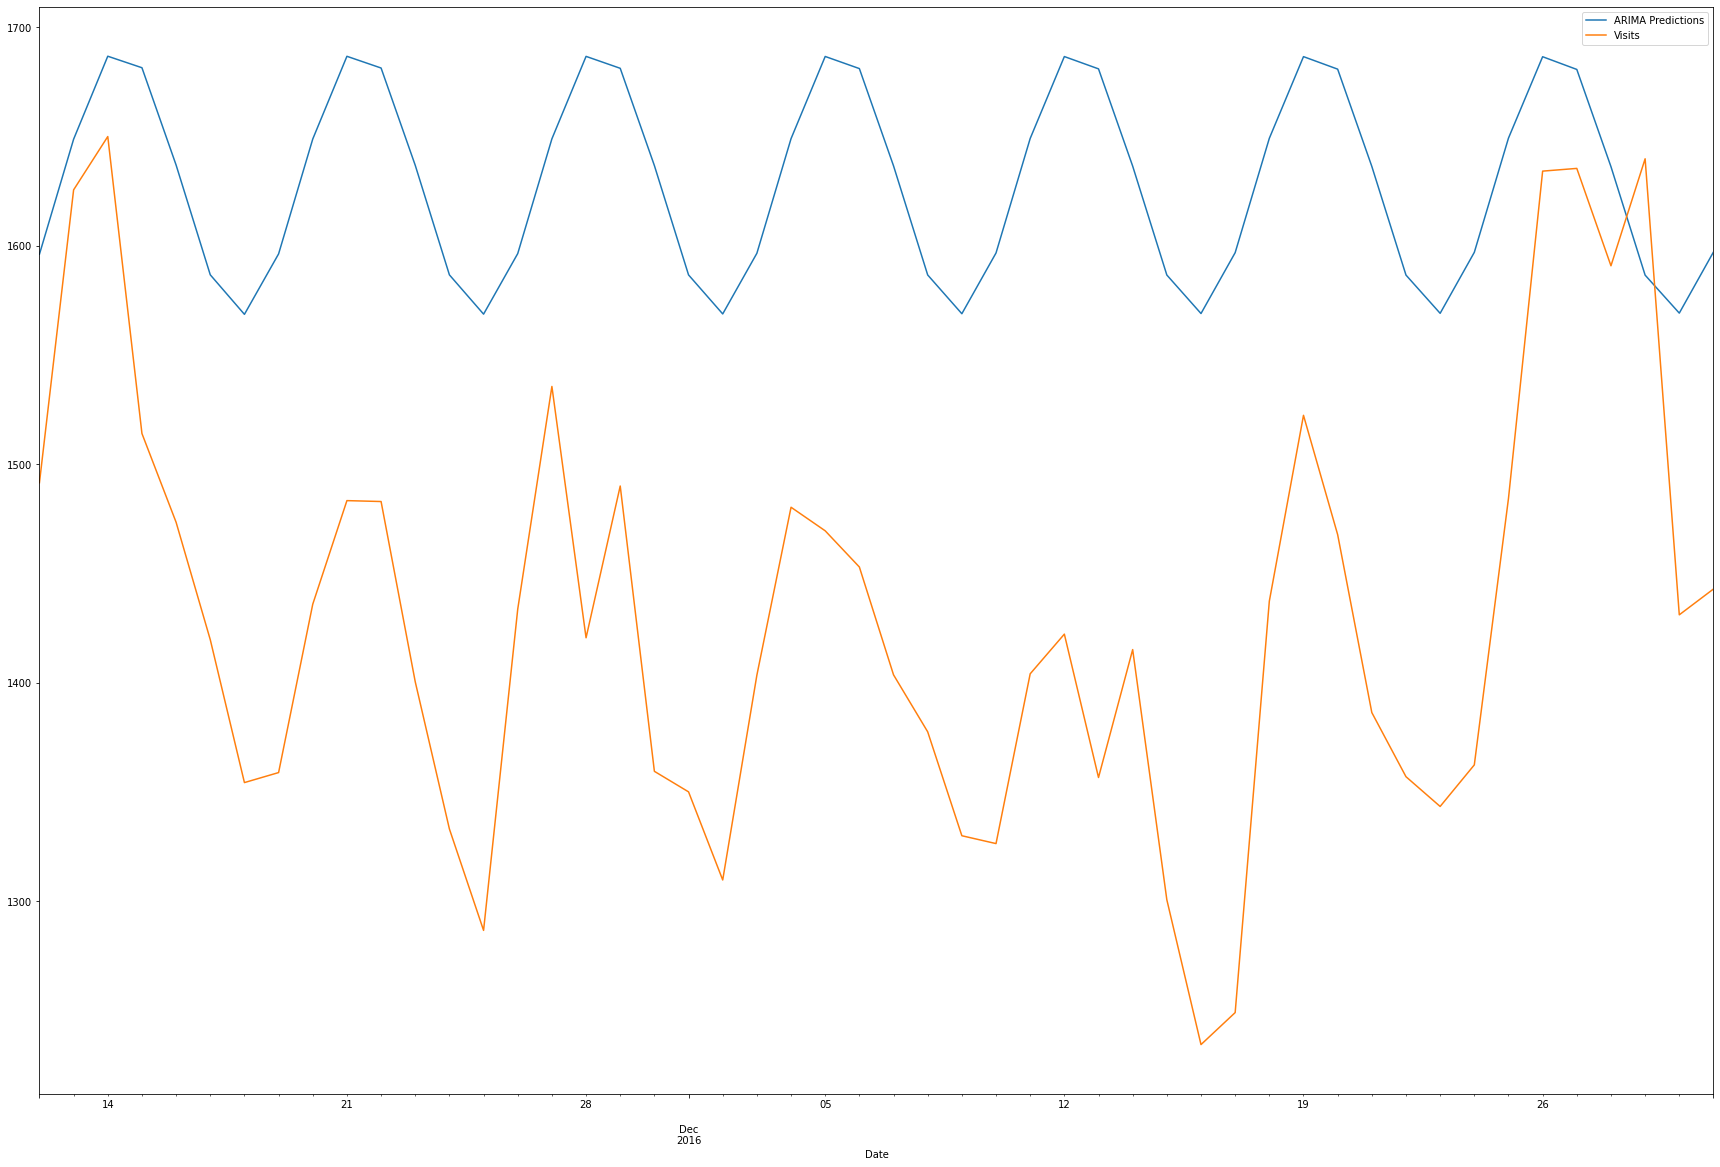

In [29]:
start = len(train)
end = len(train) + len(test) - 1
print(start, end)
pred = model_fit.predict(start=start, end=end, typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['Visits'].plot(legend=True)

In [30]:
# Metrics
test['Visits'].mean()
mae = mean_absolute_error(pred, test['Visits'])
mse = mean_squared_error(pred, test['Visits'])
rmse = np.sqrt(mse)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 199.42661229374417
Mean Squared Error: 45604.51129390797
Root Mean Squared Error: 213.55212781404913
